In [1]:
from pathlib import Path
from tkinter import Tk
from tkinter.filedialog import askopenfilenames
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.ticker as plticker
import sys

idx = pd.IndexSlice

# Define automatic naming format from file_paths
def get_name(file_path,data_type):
    name = file_path.stem.split("_")
    if data_type == 'avg':
        name = name[3]+'_'+name[4]
    elif data_type == 'indv':
        name = name[3]+'_'+name[5]
        
    return name

# Define axis labels based on parameter
def gen_param_label(param):
    param_dict = {
        'mAh':'[mAh]',
        'mass':'[mAh/g]',
        'areal':r'$\mathrm{[mAh/cm^2]}$',
        'volume':r'$\mathrm{[mAh/cm^3]$'}
    
    return param_dict[param]

In [2]:
# Open file dialog
root = Tk()
root.attributes("-topmost", True)
root.withdraw()  # stops root window from appearing
file_paths = askopenfilenames(title="Select files",
                              filetypes=[("Comma-separated values", "*.csv")])  # "Open" dialog box and return the selected path

# Convert filepaths to pathlib format
filez = []
for file in file_paths:
    file = Path(file)
    filez.append(file)
    
file_paths = filez

In [3]:
# Generate 'names' and 'param' dictionaries from file_paths
# read_csv to dataframe
names={}
params = {}
avg = []
df=[]
for i, file_path in enumerate(file_paths):   
    df_imp = pd.read_csv(file_paths[i],header=[1,2],index_col=[0,1])
    df_imp = pd.concat([df_imp], axis=1, keys=[i])
    
    df.append(df_imp)
    
    if 'avg' in file_paths[i].stem or len(df_imp.columns.values) > 2:
        data_type = 'avg'
        avg.append(True)
    else:
        data_type = 'indv'
        avg.append(False)
    
    name = get_name(file_paths[i],data_type)
    names[i] = name

    params[i] = df_imp.columns.get_level_values(1)[1]
            
df = pd.concat(df, axis=1)
df.sort_index(inplace=True)

for cell in names:
    print(cell, '->', names[cell], '->', params[cell], '-> Avg:', str(avg[cell]))

0 -> 201103_SP1 -> mass -> Avg: True
1 -> 201112_SL1 -> mass -> Avg: True


In [4]:
cathode = 1

In [5]:
### Generate df for Energy Capacity ###

# Filters
if cathode == 1:
    posCC = [3,8]
    CV = [x+1 for x in posCC]
    negCC = [x+3 for x in posCC]
    text = 'p'
else:
    negCC = [1,6,11]
    CV = [x+1 for x in negCC]
    posCC = [x+3 for x in negCC]
    text = 'n'
    
cycles = range(1,len(posCC)+1)

# Create new dataframe
df_new = []
df_list = []

for cell in names:
    # Generate new df from posCC filter
    df_new = df.loc[idx[posCC,:],idx[cell,params[cell],:]].copy()
    df_new['cycle'] = list(cycles)
    df_new.reset_index()
    df_new.set_index('cycle',inplace=True)    
    df_new.drop('cap_std', axis=1, level=2, inplace=True)
    
    # Create temp capacity arrays from posCV, posCC and negCC filters
    df_new2 = df.loc[idx[CV,:],idx[cell,params[cell],'cap']].to_numpy()
    df_new3 = df.loc[idx[posCC,:],idx[cell,params[cell],'cap']].to_numpy()
    df_new4 = df.loc[idx[negCC,:],idx[cell,params[cell],'cap']].to_numpy()
    
    # Add temp capacity arrays as columns to df_new
    df_new[cell,params[cell],'p_cap_CC']=df_new3
    df_new[cell,params[cell],text+'_cap_CV']=df_new2
    df_new[cell,params[cell],'n_cap_CC']=df_new4
    if cathode == 1:
        df_new[cell,params[cell],'p_cap_Tot']=df_new2+df_new3
    else:
        df_new[cell,params[cell],'n_cap_Tot']=df_new2+df_new4
            
    # If averaged data, do the same for std data
    if avg[cell]:
        df_new2 = df.loc[idx[CV,:],idx[cell,params[cell],'cap_std']].to_numpy()
        df_new3 = df.loc[idx[posCC,:],idx[cell,params[cell],'cap_std']].to_numpy()
        df_new4 = df.loc[idx[negCC,:],idx[cell,params[cell],'cap_std']].to_numpy()
        
        df_new[cell,params[cell],'p_std_CC']=df_new3
        df_new[cell,params[cell],text+'_std_CV']=df_new2
        df_new[cell,params[cell],'n_std_CC']=df_new4
        
        if cathode == 1:
            df_new[cell,params[cell],'p_std_Tot']=df_new2+df_new3
        else:
            df_new[cell,params[cell],'n_std_Tot']=df_new2+df_new4
            
    df_new.drop('cap', axis=1, level=2, inplace=True)
        
    df_list.append(df_new)
        
df_plot_energy = pd.concat(df_list, axis=1)
df_plot_energy

0                                                        \
             mass                                                         
         p_cap_CC  p_cap_CV    n_cap_CC   p_cap_Tot  p_std_CC  p_std_CV   
cycle                                                                     
1      160.487502  0.664663  157.142612  161.152165  1.640675  0.041520   
2      156.867328  0.637903  157.115655  157.505231  1.616944  0.030396   

                                    1                                    \
                                 mass                                     
       n_std_CC p_std_Tot    p_cap_CC  p_cap_CV    n_cap_CC   p_cap_Tot   
cycle                                                                     
1      1.643087  1.682195  167.755491  0.834278  160.334102  168.589769   
2      1.681815  1.647339  159.690759  0.835787  160.358972  160.526546   

                                               
                                               
       p_std_CC  p_std_CV  n_std_CC p_std_Tot  
cycle                                          
1      3.373444  0.109109  1.342928  3.482553  
2      1.256572  0.136687  1.327303  1.393259

In [6]:
### df for C-rate test ###

# Filters
if cathode == 1:
    posCC = [13,18,23,28,35,40,45]
    CV = [x+1 for x in posCC]
    negCC = [x+3 for x in posCC]
    text = 'p'
else:
    negCC = [16,21,26,31,38,43,48]
    CV = [x+1 for x in negCC]
    posCC = [19,24,29,34,36,41,46]
    text = 'n'

cycles = range(1,len(posCC)+1)

# Create new dataframe
df_new = []
df_list = []

for cell in names:
    # Generate new df from posCC filter
    df_new = df.loc[idx[posCC,:],idx[cell,params[cell],:]].copy()
    df_new['cycle'] = list(cycles)
    df_new.reset_index()
    df_new.set_index('cycle',inplace=True)    
    df_new.drop('cap_std', axis=1, level=2, inplace=True)
    
    # Create temp capacity arrays from posCV, posCC and negCC filters
    df_new2 = df.loc[idx[CV,:],idx[cell,params[cell],'cap']].to_numpy()
    df_new3 = df.loc[idx[posCC,:],idx[cell,params[cell],'cap']].to_numpy()
    df_new4 = df.loc[idx[negCC,:],idx[cell,params[cell],'cap']].to_numpy()
    
    # Add temp capacity arrays as columns to df_new
    df_new[cell,params[cell],'p_cap_CC']=df_new3
    df_new[cell,params[cell],text+'_cap_CV']=df_new2
    df_new[cell,params[cell],'n_cap_CC']=df_new4
    if cathode == 1:
        df_new[cell,params[cell],'p_cap_Tot']=df_new2+df_new3
    else:
        df_new[cell,params[cell],'n_cap_Tot']=df_new2+df_new4
            
    # If averaged data, do the same for std data
    if avg[cell]:
        df_new2 = df.loc[idx[CV,:],idx[cell,params[cell],'cap_std']].to_numpy()
        df_new3 = df.loc[idx[posCC,:],idx[cell,params[cell],'cap_std']].to_numpy()
        df_new4 = df.loc[idx[negCC,:],idx[cell,params[cell],'cap_std']].to_numpy()
        
        df_new[cell,params[cell],'p_std_CC']=df_new3
        df_new[cell,params[cell],text+'_std_CV']=df_new2
        df_new[cell,params[cell],'n_std_CC']=df_new4
        
        if cathode == 1:
            df_new[cell,params[cell],'p_std_Tot']=df_new2+df_new3
        else:
            df_new[cell,params[cell],'n_std_Tot']=df_new2+df_new4
            
    df_new.drop('cap', axis=1, level=2, inplace=True)
        
    df_list.append(df_new)

df_plot_rate = pd.concat(df_list, axis=1)
df_plot_rate

0                                                         \
             mass                                                          
         p_cap_CC   p_cap_CV    n_cap_CC   p_cap_Tot  p_std_CC  p_std_CV   
cycle                                                                      
1      155.147820   2.418319  146.676889  157.566139  1.941527  0.068792   
2      145.159145   2.514171  141.892551  147.673316  1.677869  0.043650   
3      139.240447   2.516056  134.308372  141.756503  1.599605  0.076043   
4      131.996412   2.598274   95.931499  134.594686  1.615313  0.109695   
5      146.781264   5.653104  146.164451  152.434368  1.990506  0.159622   
6      134.770250  11.376760  145.424648  146.147010  1.415361  0.373771   
7      119.525132  24.850954  144.173989  144.376086  1.404244  1.105411   

                                    1                                     \
                                 mass                                      
       n_std_CC p_std_Tot    p_cap_CC   p_cap_CV    n_cap_CC   p_cap_Tot   
cycle                                                                      
1      3.179921  2.010319  158.044315   3.021889  150.473546  161.066204   
2      1.297656  1.721519  147.405741   3.131611  144.420037  150.537352   
3      1.800679  1.675648  141.448046   3.098352  137.136250  144.546398   
4      3.709995  1.725008  134.133824   3.167630   91.354269  137.301454   
5      2.716986  2.150129  148.831750   6.930269  149.645889  155.762019   
6      1.923579  1.789132  134.570556  14.066139  148.377963  148.636694   
7      1.289782  2.509655  116.007333  30.715750  146.318426  146.723083   

                                               
                                               
       p_std_CC  p_std_CV  n_std_CC p_std_Tot  
cycle                                          
1      1.020713  0.409212  1.282272  1.429925  
2      0.918743  0.388717  1.474549  1.307459  
3      1.238278  0.254717  1.499801  1.492994  
4      1.265465  0.268617  1.192937  1.534082  
5      1.033054  0.491904  1.358774  1.524958  
6      0.583057  1.172585  1.364500  1.755642  
7      1.580188  2.490984  1.242573  4.071172

In [7]:
### df for Degradation test ###

# Filters
if cathode == 1:
    init = 52
    posCC = [init]
    for i in range(1,22):
        if i == 10 or i == 21:
            posCC.append(posCC[i-1]+7)
        else:
            posCC.append(posCC[i-1]+5)
            
    CV = [x+1 for x in posCC]
    negCC = [x+3 for x in posCC]
    text = 'p'
else:
    negCC = [55]
    posCC = [58]
    for i in range(1,22):
        if i==10 or i==21:
            negCC.append(negCC[i-1]+7)
            posCC.append(posCC[i-1]+7)           
        else:
            negCC.append(negCC[i-1]+5)
            posCC.append(posCC[i-1]+5)
            
    CV = [x+1 for x in negCC]
    text = 'n'
    
cycles = range(1,len(posCC)+1)

print(negCC)
print(posCC)

#sys.exit()

# Create new dataframe
df_new = []
df_list = []

for cell in names:
    # Generate new df from posCC filter
    df_new = df.loc[idx[posCC,:],idx[cell,params[cell],:]].copy()
    df_new['cycle'] = list(cycles)
    df_new.reset_index()
    df_new.set_index('cycle',inplace=True)    
    df_new.drop('cap_std', axis=1, level=2, inplace=True)
    
    # Create temp capacity arrays from posCV, posCC and negCC filters
    df_new2 = df.loc[idx[CV,:],idx[cell,params[cell],'cap']].to_numpy()
    df_new3 = df.loc[idx[posCC,:],idx[cell,params[cell],'cap']].to_numpy()
    df_new4 = df.loc[idx[negCC,:],idx[cell,params[cell],'cap']].to_numpy()
    
    # Add temp capacity arrays as columns to df_new
    df_new[cell,params[cell],'p_cap_CC']=df_new3
    df_new[cell,params[cell],text+'_cap_CV']=df_new2
    df_new[cell,params[cell],'n_cap_CC']=df_new4
    if cathode == 1:
        df_new[cell,params[cell],'p_cap_Tot']=df_new2+df_new3
    else:
        df_new[cell,params[cell],'n_cap_Tot']=df_new2+df_new4
            
    # If averaged data, do the same for std data
    if avg[cell]:
        df_new2 = df.loc[idx[CV,:],idx[cell,params[cell],'cap_std']].to_numpy()
        df_new3 = df.loc[idx[posCC,:],idx[cell,params[cell],'cap_std']].to_numpy()
        df_new4 = df.loc[idx[negCC,:],idx[cell,params[cell],'cap_std']].to_numpy()
        
        df_new[cell,params[cell],'p_std_CC']=df_new3
        df_new[cell,params[cell],text+'_std_CV']=df_new2
        df_new[cell,params[cell],'n_std_CC']=df_new4
        
        if cathode == 1:
            df_new[cell,params[cell],'p_std_Tot']=df_new2+df_new3
        else:
            df_new[cell,params[cell],'n_std_Tot']=df_new2+df_new4
            
    df_new.drop('cap', axis=1, level=2, inplace=True)
        
    df_list.append(df_new)

df_plot_deg = pd.concat(df_list, axis=1)
df_plot_deg

[55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152, 157, 164]
[52, 57, 62, 67, 72, 77, 82, 87, 92, 97, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 161]


0                                                         \
             mass                                                          
         p_cap_CC   p_cap_CV    n_cap_CC   p_cap_Tot  p_std_CC  p_std_CV   
cycle                                                                      
1      138.067668  13.073906  140.633883  151.141575  2.463075  0.427521   
2      127.782135  13.334512  140.599894  141.116646  1.536048  0.377536   
3      126.859023  13.377653  140.352407  140.236677  2.274081  0.410875   
4      127.022604  13.428766  140.284822  140.451370  1.122081  0.402793   
5      126.664572  13.808789  139.869031  140.473361  1.062242  0.558440   
6      126.189137  13.850848  139.938289  140.039985  0.995295  0.621995   
7      125.794224  14.102551  139.695473  139.896775  0.706504  0.943581   
8      125.384943  14.455882  139.464837  139.840825  0.537959  0.844579   
9      125.018206  14.571438  139.371711  139.589644  0.480554  0.778139   
10     124.916616  14.645450  139.637926  139.562067  0.592914  0.821812   
11     150.838039   0.819682  156.665859  151.657721  1.439727  0.066741   
12     142.170666  13.704111  140.063868  155.874777  2.538999  0.894696   
13     126.861393  14.011779  140.417502  140.873172  0.557815  0.950300   
14     126.303119  14.227396  139.771696  140.530515  0.408344  0.909850   
15     125.458539  14.373641  139.311983  139.832180  0.639018  0.924901   
16     125.082725  14.344201  139.501438  139.426927  0.644772  0.852527   
17     125.086109  14.500379  139.170250  139.586488  0.548927  0.900715   
18     124.527229  14.782279  138.924217  139.309508  0.665031  0.849781   
19     124.230886  14.822491  138.832914  139.053376  0.447166  0.842526   
20     124.014769  14.897774  138.745095  138.912544  0.332990  0.891514   
21     123.797623  15.040696  138.796593  138.838319  0.574215  0.806545   
22     150.207487   0.837676  156.004330  151.045163  1.389834  0.054024   

                                    1                                     \
                                 mass                                      
       n_std_CC p_std_Tot    p_cap_CC   p_cap_CV    n_cap_CC   p_cap_Tot   
cycle                                                                      
1      2.369153  2.890596  138.814250  15.530259  143.701444  154.344509   
2      1.771520  1.913584  127.767130  15.986704  142.973880  143.753833   
3      1.377825  2.684955  126.889222  16.113324  142.871481  143.002546   
4      1.484880  1.524875  126.913722  16.023148  142.847537  142.936870   
5      1.541267  1.620682  126.671185  16.269148  142.544917  142.940333   
6      1.114492  1.617290  126.104074  16.532139  142.368194  142.636213   
7      1.229757  1.650085  125.764602  16.688407  142.185907  142.453009   
8      1.265124  1.382538  125.602167  16.668176  142.154944  142.270343   
9      1.377708  1.258693  125.456954  16.802370  142.323463  142.259324   
10     1.527474  1.414726  125.455435  16.961926  142.193500  142.417361   
11     1.529853  1.506468  153.617241   0.993824  159.519333  154.611065   
12     2.593923  3.433695  143.041083  16.479167  142.758454  159.520250   
13     1.172058  1.508116  126.137639  16.703731  142.790287  142.841370   
14     1.233153  1.318195  125.682102  17.115028  142.150528  142.797130   
15     1.278767  1.563919  125.118704  17.012231  141.595185  142.130935   
16     1.260717  1.497298  124.394065  17.256565  141.495148  141.650630   
17     1.124158  1.449642  124.262435  17.301843  141.456926  141.564278   
18     1.151316  1.514812  124.096111  17.439324  141.256537  141.535435   
19     1.119141  1.289691  123.786991  17.575157  141.474231  141.362148   
20     1.261753  1.224503  123.780704  17.822963  141.548759  141.603667   
21     1.551014  1.380759  123.792778  17.843648  141.021889  141.636426   
22     1.493135  1.443857  153.014861   1.102889  158.779583  154.117750   

                                               
              

0 --> n_cap_CC


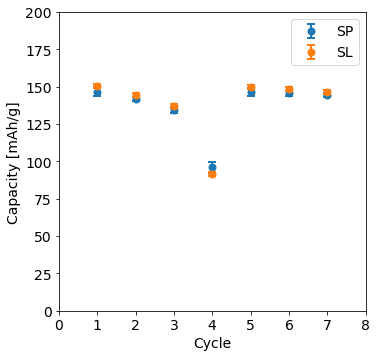

In [16]:
##### Set plot DataFrame
df_p = df_plot_rate

# Set x upper bound
upper = len(df_p.index)+1

# Create figure and axes
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(5.5, 5.5))

# Params
ax.set_ylim(ymin=0, ymax=200)
ax.set_xlim(xmin=0, xmax=upper)

# Type
if cathode == 1:
    y_values = ['n_cap_CC'] # ['p_cap_Tot', 'n_cap_CC']
    yerr_values = ['n_std_CC'] # ['p_std_Tot', 'n_std_CC']
    ax.set_ylim(ymin=0, ymax=200)
else:
    y_values = ['p_cap_CC'] # ['p_cap_CC', 'n_cap_Tot']
    yerr_values = ['p_std_CC'] # ['p_std_CC', 'n_std_Tot']
    ax.set_ylim(ymin=0, ymax=400)

# Plot cycle data
for i, y_val in enumerate(y_values):
    print(i, '-->', y_val)
    for cell in names:
        x = df_p.index
        y = df_p.loc[idx[:],idx[cell, params[cell], y_val]]
        if avg[cell]:
            yerr_data = df_p.loc[idx[:],idx[cell, params[cell], yerr_values[i]]]
            plt.errorbar(x, y, yerr=yerr_data, fmt='o', capsize=4, elinewidth=2, markeredgewidth=2, label = names[cell] + '_' + y.name[2])    
        else:
            plt.scatter(x, y, label = names[cell] + '_' + y.name[2])
        
loc = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
    
plt.xlabel("Cycle")
plt.ylabel('Capacity '+gen_param_label(params[0]))

leg = plt.legend(loc='best')
if cathode == 1:
    leg.get_texts()[0].set_text('SP')
    leg.get_texts()[1].set_text('SL')
    #leg.get_texts()[0].set_text('Charge (CC+CV)')
    #leg.get_texts()[1].set_text('Discharge (CC)')
else:
    leg.get_texts()[0].set_text('SL')
    leg.get_texts()[1].set_text('SP')
    #leg.get_texts()[0].set_text('Positive (CC)')
    #leg.get_texts()[1].set_text('Negative (CC+CV)')

plt.savefig(file_paths[cell].parent.joinpath('{}_{}.svg'.format('rate_cycles',names[cell])),
            format='svg', 
            dpi=600, 
            bbox_inches = 'tight')
plt.show()

0 --> n_cap_CC


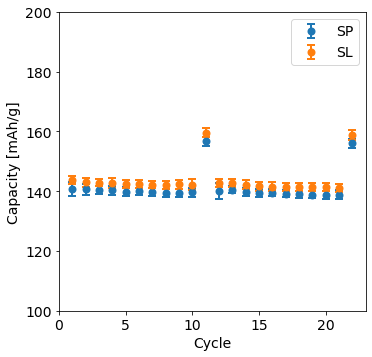

In [15]:
##### Set plot DataFrame
df_p = df_plot_deg

# Set x upper bound
upper = len(df_p.index)+1

# Create figure and axes
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(5.5, 5.5))

# Params
ax.set_xlim(xmin=0, xmax=upper)

if cathode == 1:
    y_values = ['n_cap_CC'] # ['p_cap_Tot', 'n_cap_CC']
    yerr_values = ['n_std_CC'] # ['p_std_Tot', 'n_std_CC']
    ax.set_ylim(ymin=100, ymax=200)
else:
    y_values = ['p_cap_CC'] # ['p_cap_CC', 'n_cap_Tot']
    yerr_values = ['p_std_CC'] # ['p_std_CC', 'n_std_Tot']
    ax.set_ylim(ymin=0, ymax=350)

# Plot cycle data
for i, y_val in enumerate(y_values):
    print(i, '-->', y_val)
    for cell in names:
        x = df_p.index
        y = df_p.loc[idx[:],idx[cell, params[cell], y_val]]
        if avg[cell]:
            yerr_data = df_p.loc[idx[:],idx[cell, params[cell], yerr_values[i]]]
            plt.errorbar(x, y, yerr=yerr_data, fmt='o', capsize=4, elinewidth=2, markeredgewidth=2, label = names[cell] + '_' + y.name[2])    
        else:
            plt.scatter(x, y, label = names[cell] + '_' + y.name[2])
        
loc = plticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
    
plt.xlabel("Cycle")
plt.ylabel('Capacity '+gen_param_label(params[0]))

leg = plt.legend(loc='best')
if cathode == 1:
    leg.get_texts()[0].set_text('SP')
    leg.get_texts()[1].set_text('SL')
    #leg.get_texts()[0].set_text('Charge (CC+CV)')
    #leg.get_texts()[1].set_text('Discharge (CC)')
else:
    leg.get_texts()[0].set_text('SL')
    leg.get_texts()[1].set_text('SP')
    #leg.get_texts()[0].set_text('Positive (CC)')
    #leg.get_texts()[1].set_text('Negative (CC+CV)')

plt.savefig(file_paths[cell].parent.joinpath('{}_{}.svg'.format('deg_cycles',names[cell])),
            format='svg', 
            dpi=600, 
            bbox_inches = 'tight')
plt.show()